<a href="https://colab.research.google.com/github/OJB-Quantum/QC-Hardware-How-To/blob/main/Jupyter%20Notebook%20Scripts/Standard_Quantum_Limit_Example_Plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Authored by Onri Jay Benally (2025)

Open Access (CC-BY-4.0)

# Standard Quantum Limit (SQL) for a Free Test Mass

We model a measurement of the displacement $(x(t))$ of a single free test mass of mass $(m)$,
probed at *angular* frequency $(\Omega = 2\pi f)$ with laser light of wavelength $(\lambda_0)$
and input power $(P_{\text{in}})$.

---

## 1. Mechanical response of a free mass

A free mass responds to a force $(F(\Omega))$ according to

$$
x(\Omega) = \chi(\Omega)\,F(\Omega),
$$

where $(\chi(\Omega))$ is the **mechanical susceptibility**.

For a free mass (no restoring spring):

$$
\chi(\Omega)
= \frac{1}{-m\Omega^{2}}
\quad\Rightarrow\quad
\bigl|\chi(\Omega)\bigr|
= \frac{1}{m\Omega^{2}}.
$$

---

## 2. Quantum noise contributions

The displacement noise comes from two quantum sources:

1. **Shot noise** (photon counting noise in the readout)
2. **Radiation‑pressure noise** (random force from photon momentum kicks)

Both are described as **one‑sided displacement power spectral densities (PSDs)**
$(S(\Omega))$ with units of $(\text{m}^2/\text{Hz})$.

### 2.1 Shot‑noise displacement spectrum

For a simple Michelson‑type interferometer operated at mid‑fringe, the shot‑noise‑limited
displacement spectrum can be written as

$$
S_{\text{sn}}(\Omega)
= \frac{\hbar c\,\lambda_0}{2\pi\,P_{\text{in}}},
$$

where

- $(\hbar)$ is the reduced Planck constant,
- $(c)$ is the speed of light,
- $(\lambda_0)$ is the laser wavelength,
- $(P_{\text{in}})$ is the incident laser power.

**English description:** this term *decreases* when you increase the laser power,
because more photons per second give a cleaner average at the detector.

### 2.2 Radiation‑pressure displacement spectrum

Quantum radiation‑pressure noise (QRPN) drives the mirror with a fluctuating force.
For the same interferometer, the resulting displacement spectrum is

$$
S_{\text{rp}}(\Omega)
= \frac{4\pi}{m^{2}\Omega^{4}}\,
    \frac{\hbar P_{\text{in}}}{c\,\lambda_0}.
$$

**English description:** this term *increases* with laser power and *decreases*
with heavier test masses and higher measurement frequencies.

### 2.3 Total quantum‑noise spectrum

For a given power $(P_{\text{in}})$, the total quantum displacement noise is

$$
S_{\text{qn}}(\Omega; P_{\text{in}})
= S_{\text{sn}}(\Omega; P_{\text{in}})
+ S_{\text{rp}}(\Omega; P_{\text{in}}).
$$

In amplitude spectral density (what you actually plot):

$$
x_{\text{qn}}(\Omega; P_{\text{in}})
= \sqrt{S_{\text{qn}}(\Omega; P_{\text{in}})}.
$$

---

## 3. Standard Quantum Limit (SQL)

The **standard quantum limit** is the minimum possible total quantum noise you get
by adjusting the optical power $(P_{\text{in}})$ only, with no fancy correlations or
squeezing.

Mathematically, we minimize the total PSD with respect to input power:

$$
\frac{\partial}{\partial P_{\text{in}}}
S_{\text{qn}}(\Omega; P_{\text{in}}) = 0.
$$

Carrying out this minimization gives the *free‑mass* SQL

$$
S_{\text{SQL}}(\Omega)
= \frac{2\hbar}{m\Omega^{2}}.
$$

Equivalently, expressed in terms of the (magnitude of the) susceptibility:

$$
S_{\text{SQL}}(\Omega)
= 2\hbar\,\bigl|\chi(\Omega)\bigr|.
$$

This is the expression commonly used when normalizing measured spectra or models
to “the SQL curve” in displacement units.

The corresponding **amplitude spectral density**, which is what gets plotted in
the SQL code, is

$$
x_{\text{SQL}}(\Omega)
= \sqrt{S_{\text{SQL}}(\Omega)}
= \sqrt{\frac{2\hbar}{m\Omega^{2}}}.
$$

---

## 4. Simple idea map

```text
Quantum noise (displacement)
├── Shot noise S_sn(Ω; P_in)  ∝  1 / P_in
└── Radiation pressure S_rp(Ω; P_in)  ∝  P_in / (m² Ω⁴)
     └── Both combine: S_qn = S_sn + S_rp
          └── Minimize over P_in → Standard Quantum Limit S_SQL(Ω)
               └── For free mass: S_SQL(Ω) = 2ħ / (m Ω²)
```

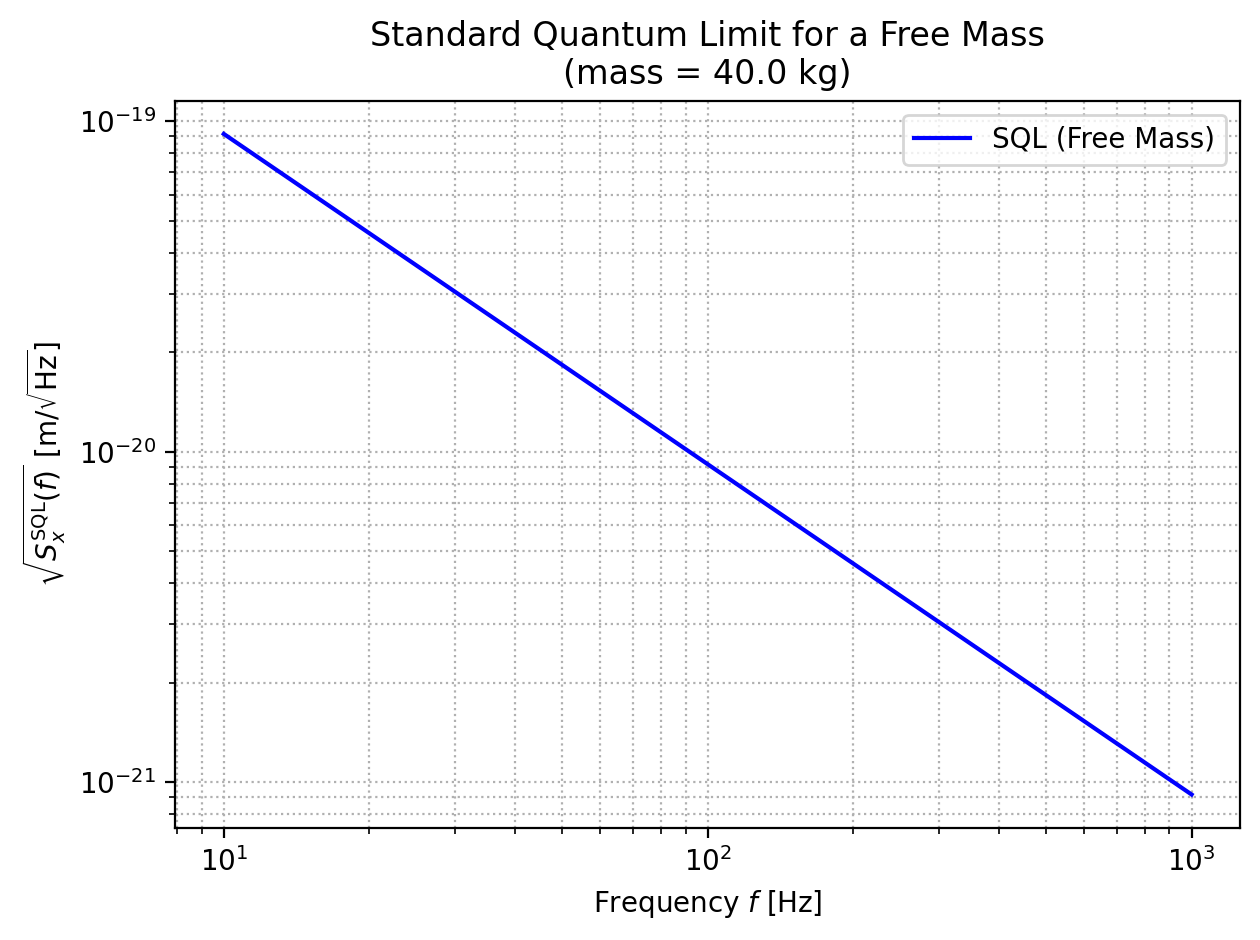

In [3]:
"""
Standard Quantum Limit (SQL) demo for a free mass.

This Colab-ready script computes and plots the displacement
standard quantum limit for a free mass (e.g., an interferometer
test mass), using

    S_x_SQL(Ω) = 2 ħ / (m Ω^2),

and then converts to a PSD versus frequency f in Hz.
"""

from typing import Final

import numpy as np
import matplotlib.pyplot as plt

# Optional static analysis in Colab (uncomment if desired).
# !pip install pylint

# ---------------------------------------------------------------------------
# Control knobs
# ---------------------------------------------------------------------------

HBAR: Final[float] = 1.054_571_817e-34  # Reduced Planck constant [J·s]

# A LIGO-like test mass (40 kg). Change this for other systems.
DEFAULT_MASS_KG: Final[float] = 40.0

# Frequency range for the plot [Hz].
FREQ_MIN_HZ: Final[float] = 10.0
FREQ_MAX_HZ: Final[float] = 1_000.0
NUM_POINTS: Final[int] = 500


# ---------------------------------------------------------------------------
# Physics helpers
# ---------------------------------------------------------------------------

def mechanical_susceptibility_free_mass(
    omega: np.ndarray,
    mass_kg: float,
) -> np.ndarray:
    """Return the free-mass mechanical susceptibility χ(Ω).

    Args:
        omega: Angular frequency array Ω in rad/s.
        mass_kg: Mass m in kilograms.

    Returns:
        Complex numpy array χ(Ω) = 1 / (m Ω^2) in units of m/N.
    """
    # Avoid division by zero at Ω = 0 by using a tiny floor.
    omega_safe = np.where(omega == 0.0, 1e-30, omega)
    chi = 1.0 / (mass_kg * omega_safe**2)
    return chi.astype(np.complex128)


def sql_displacement_psd_omega(
    omega: np.ndarray,
    mass_kg: float,
) -> np.ndarray:
    """Compute the displacement SQL PSD S_x_SQL(Ω).

    This uses the general formula:

        S_x_SQL(Ω) = 2 ħ |χ(Ω)|,

    specialized to a free mass so that χ(Ω) = 1 / (m Ω^2).

    Args:
        omega: Angular frequency array Ω in rad/s.
        mass_kg: Mass m in kilograms.

    Returns:
        One-sided PSD S_x_SQL(Ω) in units of m^2·s (m^2 per rad/s).
    """
    chi = mechanical_susceptibility_free_mass(omega=omega, mass_kg=mass_kg)
    return 2.0 * HBAR * np.abs(chi)


def sql_displacement_psd_frequency(
    freq_hz: np.ndarray,
    mass_kg: float,
) -> np.ndarray:
    """Compute S_x_SQL(f) from S_x_SQL(Ω) with consistent units.

    We use the relation:

        Ω = 2π f,  dΩ = 2π df,  S_x(f) df = S_x(Ω) dΩ,

    which implies:

        S_x(f) = 2π S_x(Ω = 2π f).

    Args:
        freq_hz: Frequency array in Hz.
        mass_kg: Mass m in kilograms.

    Returns:
        One-sided PSD S_x_SQL(f) in units of m^2/Hz.
    """
    omega = 2.0 * np.pi * freq_hz
    s_x_omega = sql_displacement_psd_omega(omega=omega, mass_kg=mass_kg)
    s_x_freq = 2.0 * np.pi * s_x_omega
    return s_x_freq


# ---------------------------------------------------------------------------
# Plotting
# ---------------------------------------------------------------------------

def plot_sql_free_mass(
    mass_kg: float = DEFAULT_MASS_KG,
    f_min_hz: float = FREQ_MIN_HZ,
    f_max_hz: float = FREQ_MAX_HZ,
    num_points: int = NUM_POINTS,
) -> None:
    """Plot the amplitude spectral density for the free-mass SQL.

    Args:
        mass_kg: Mass of the test object in kilograms.
        f_min_hz: Minimum frequency in Hz.
        f_max_hz: Maximum frequency in Hz.
        num_points: Number of points in the log-spaced frequency grid.

    Returns:
        None. Displays a matplotlib figure.
    """
    freq_hz = np.logspace(
        np.log10(f_min_hz),
        np.log10(f_max_hz),
        num_points,
    )

    s_x_sql = sql_displacement_psd_frequency(freq_hz=freq_hz, mass_kg=mass_kg)
    asd_x_sql = np.sqrt(s_x_sql)  # m / sqrt(Hz)

    fig = plt.figure(dpi=200)
    ax = fig.add_subplot(111)

    # CHANGE: Added color='blue' to the plot arguments
    ax.loglog(freq_hz, asd_x_sql, color='blue', label='SQL (Free Mass)')

    ax.set_xlabel("Frequency $f$ [Hz]")
    ax.set_ylabel(r"$\sqrt{S_{x}^{\mathrm{SQL}}(f)}$ [m/$\sqrt{\mathrm{Hz}}$]")
    ax.set_title(
        "Standard Quantum Limit for a Free Mass\n"
        f"(mass = {mass_kg:.1f} kg)"
    )
    ax.grid(True, which="both", linestyle=":")
    ax.legend() # Added legend for clarity

    plt.tight_layout()
    plt.show()


def main() -> None:
    """Run a demo plot of the free-mass SQL."""
    plot_sql_free_mass()


if __name__ == "__main__":
    main()